# OhioT1DM Dataset - Glucose & Insulin Prediction Models

This notebook trains machine learning models for:
1. **Glucose Prediction**: Predicting future blood glucose levels
2. **Insulin Recommendation**: Predicting optimal insulin dosage

**Dataset**: OhioT1DM - Type 1 Diabetes dataset with CGM, insulin, and meal data

**Models**: LSTM (for glucose time-series), XGBoost (for insulin recommendation)

## 1. Import Required Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import xml.etree.ElementTree as ET

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Machine Learning
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Deep Learning (LSTM for time series)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# XGBoost for insulin prediction
import xgboost as xgb
from xgboost import XGBRegressor

# Save models
import joblib
import pickle

# Warnings
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"XGBoost version: {xgb.__version__}")

Libraries imported successfully!
TensorFlow version: 2.19.0
XGBoost version: 3.1.2


## 2. Load the OhioT1DM Dataset

The OhioT1DM dataset contains:
- **CGM (Continuous Glucose Monitor)**: Blood glucose readings every 5 minutes
- **Insulin**: Basal and bolus insulin doses
- **Meal/Carbs**: Carbohydrate intake from meals
- **Exercise**: Physical activity data
- **Timestamps**: All data is timestamped

Dataset structure: Each patient has separate XML files for different data types.

In [2]:
# Define path to OhioT1DM dataset
# Update this path to where you downloaded the dataset
DATA_PATH = './OhioT1DM_data/'  # Change to your dataset path

# Patient IDs in OhioT1DM dataset
# Training set: 559, 563, 570, 575, 588, 591
# Testing set: 540, 544, 552, 567, 584, 596
PATIENT_IDS = ['559', '563', '570', '575', '588', '591']

def load_patient_xml_data(patient_id, data_type):
    """
    Load XML data for a specific patient and data type

    Parameters:
    - patient_id: Patient identifier (e.g., '559')
    - data_type: Type of data ('glucose', 'insulin', 'meal', 'exercise')

    Returns:
    - DataFrame with the parsed data
    """
    file_path = f"{DATA_PATH}{patient_id}-ws-training.xml"

    try:
        tree = ET.parse(file_path)
        root = tree.getroot()

        data_list = []

        if data_type == 'glucose':
            for event in root.findall('.//glucose_level/event'):
                timestamp = event.get('ts')
                value = event.get('value')
                data_list.append({
                    'timestamp': pd.to_datetime(timestamp),
                    'glucose': float(value)
                })

        elif data_type == 'insulin':
            # Basal insulin
            for event in root.findall('.//basal/event'):
                timestamp = event.get('ts')
                value = event.get('value')
                data_list.append({
                    'timestamp': pd.to_datetime(timestamp),
                    'basal_insulin': float(value),
                    'bolus_insulin': 0.0
                })

            # Bolus insulin
            for event in root.findall('.//bolus/event'):
                timestamp = event.get('ts')
                dose_normal = event.get('dose_normal', '0')
                dose_square = event.get('dose_square', '0')
                total_dose = float(dose_normal) + float(dose_square)
                data_list.append({
                    'timestamp': pd.to_datetime(timestamp),
                    'basal_insulin': 0.0,
                    'bolus_insulin': total_dose
                })

        elif data_type == 'meal':
            for event in root.findall('.//meal/event'):
                timestamp = event.get('ts')
                carbs = event.get('carbs', '0')
                data_list.append({
                    'timestamp': pd.to_datetime(timestamp),
                    'carbs': float(carbs)
                })

        elif data_type == 'exercise':
            for event in root.findall('.//exercise/event'):
                timestamp = event.get('ts')
                duration = event.get('duration', '0')
                intensity = event.get('intensity', 'medium')
                data_list.append({
                    'timestamp': pd.to_datetime(timestamp),
                    'exercise_duration': float(duration),
                    'exercise_intensity': intensity
                })

        return pd.DataFrame(data_list)

    except Exception as e:
        print(f"Error loading {data_type} data for patient {patient_id}: {e}")
        return pd.DataFrame()

print("Data loading functions defined successfully!")

Data loading functions defined successfully!


In [4]:
from google.colab import files
import os

# Create the directory if it doesn't exist
DATA_PATH = './OhioT1DM_data/'
os.makedirs(DATA_PATH, exist_ok=True)

print("Please upload your OhioT1DM dataset XML files (e.g., 559-ws-training.xml) into the directory.")

uploaded = files.upload()

for filename in uploaded.keys():
    print(f'User uploaded file "{filename}" with length {len(uploaded[filename])} bytes')
    # Move the uploaded file to the DATA_PATH directory
    with open(os.path.join(DATA_PATH, filename), "wb") as f:
        f.write(uploaded[filename])
    print(f'Moved "{filename}" to {DATA_PATH}')

print("\n✓ All specified files have been uploaded to the OhioT1DM_data directory.")

Please upload your OhioT1DM dataset XML files (e.g., 559-ws-training.xml) into the directory.


Saving 559-ws-training.xml to 559-ws-training.xml
Saving 563-ws-training.xml to 563-ws-training.xml
Saving 570-ws-training.xml to 570-ws-training.xml
Saving 575-ws-training.xml to 575-ws-training.xml
Saving 588-ws-training.xml to 588-ws-training.xml
Saving 591-ws-training.xml to 591-ws-training.xml
User uploaded file "559-ws-training.xml" with length 3793192 bytes
Moved "559-ws-training.xml" to ./OhioT1DM_data/
User uploaded file "563-ws-training.xml" with length 3866003 bytes
Moved "563-ws-training.xml" to ./OhioT1DM_data/
User uploaded file "570-ws-training.xml" with length 3901406 bytes
Moved "570-ws-training.xml" to ./OhioT1DM_data/
User uploaded file "575-ws-training.xml" with length 3950889 bytes
Moved "575-ws-training.xml" to ./OhioT1DM_data/
User uploaded file "588-ws-training.xml" with length 4189430 bytes
Moved "588-ws-training.xml" to ./OhioT1DM_data/
User uploaded file "591-ws-training.xml" with length 3851976 bytes
Moved "591-ws-training.xml" to ./OhioT1DM_data/

✓ All spe

In [23]:
# Load data for all patients
all_patients_data = []

for patient_id in PATIENT_IDS:
    print(f"\nLoading data for patient {patient_id}...")

    # Load different data types
    glucose_df = load_patient_xml_data(patient_id, 'glucose')
    insulin_df = load_patient_xml_data(patient_id, 'insulin')
    meal_df = load_patient_xml_data(patient_id, 'meal')
    exercise_df = load_patient_xml_data(patient_id, 'exercise')

    # Store patient data
    patient_data = {
        'patient_id': patient_id,
        'glucose': glucose_df,
        'insulin': insulin_df,
        'meal': meal_df,
        'exercise': exercise_df
    }

    all_patients_data.append(patient_data)

    print(f"  Glucose records: {len(glucose_df)}")
    print(f"  Insulin records: {len(insulin_df)}")
    print(f"  Meal records: {len(meal_df)}")
    print(f"  Exercise records: {len(exercise_df)}")

print("\n✓ Data loaded successfully for all patients!")


Loading data for patient 559...
  Glucose records: 10796
  Insulin records: 315
  Meal records: 150
  Exercise records: 20

Loading data for patient 563...
  Glucose records: 12124
  Insulin records: 434
  Meal records: 129
  Exercise records: 17

Loading data for patient 570...
  Glucose records: 10982
  Insulin records: 444
  Meal records: 136
  Exercise records: 25

Loading data for patient 575...
  Glucose records: 11866
  Insulin records: 313
  Meal records: 243
  Exercise records: 5

Loading data for patient 588...
  Glucose records: 12640
  Insulin records: 256
  Meal records: 221
  Exercise records: 36

Loading data for patient 591...
  Glucose records: 10847
  Insulin records: 374
  Meal records: 212
  Exercise records: 23

✓ Data loaded successfully for all patients!


## 3. Merge and Preprocess Data

Combine all data sources into a single time-aligned DataFrame with 5-minute intervals.

In [31]:
def merge_patient_data(patient_data):
    """
    Merge all data sources for a patient into single DataFrame
    """
    glucose_df = patient_data['glucose'].copy()
    insulin_df = patient_data['insulin'].copy()
    meal_df = patient_data['meal'].copy()

    if glucose_df.empty:
        return pd.DataFrame()

    # Set timestamp as index for glucose (our primary data)
    glucose_df.set_index('timestamp', inplace=True)
    glucose_df = glucose_df.sort_index()

    # Create 5-minute interval index
    start_time = glucose_df.index.min()
    end_time = glucose_df.index.max()
    time_index = pd.date_range(start=start_time, end=end_time, freq='5min')

    # Reindex glucose data
    df = glucose_df.reindex(time_index)
    df['glucose'] = df['glucose'].interpolate(method='linear')

    # Initialize insulin and carb columns to zero
    df['basal_insulin'] = 0.0
    df['bolus_insulin'] = 0.0
    df['carbs'] = 0.0

    # Merge insulin data
    if not insulin_df.empty:
        insulin_df.set_index('timestamp', inplace=True)
        insulin_df = insulin_df.sort_index()

        # Aggregate insulin events at the same timestamp to ensure unique index
        # Sum bolus and take last basal if multiple entries at same timestamp
        insulin_agg = insulin_df.groupby(insulin_df.index).agg({
            'basal_insulin': 'last',
            'bolus_insulin': 'sum'
        })

        # Basal: ffill over the main time_index (basal rate holds constant)
        basal_filled = insulin_agg['basal_insulin'].reindex(time_index, method='ffill').fillna(0)
        df['basal_insulin'] = basal_filled

        # Bolus: resample and sum over 5-min intervals, then reindex
        bolus_resampled = insulin_agg['bolus_insulin'].resample('5min').sum().reindex(time_index).fillna(0)
        df['bolus_insulin'] = bolus_resampled

        # Debug prints for one patient
        if patient_data['patient_id'] == PATIENT_IDS[0]:
            print(f"  [DEBUG {patient_data['patient_id']}] insulin_agg bolus head:\n{insulin_agg['bolus_insulin'].head()}")
            print(f"  [DEBUG {patient_data['patient_id']}] bolus_resampled head:\n{bolus_resampled.head()}")
            print(f"  [DEBUG {patient_data['patient_id']}] bolus_resampled max: {bolus_resampled.max()}")

    else:
        df['basal_insulin'] = 0.0
        df['bolus_insulin'] = 0.0

    # Merge meal data (sum carbs in 5-min windows)
    if not meal_df.empty:
        meal_df.set_index('timestamp', inplace=True)
        meal_df = meal_df.sort_index()

        # Aggregate meal events at the same timestamp to ensure unique index
        meal_agg = meal_df.groupby(meal_df.index).agg({'carbs': 'sum'})

        # Resample carbs as sum over 5-min intervals, then reindex
        carbs_resampled = meal_agg['carbs'].resample('5min').sum().reindex(time_index).fillna(0)
        df['carbs'] = carbs_resampled

        # Debug prints for one patient
        if patient_data['patient_id'] == PATIENT_IDS[0]:
            print(f"  [DEBUG {patient_data['patient_id']}] meal_agg carbs head:\n{meal_agg['carbs'].head()}")
            print(f"  [DEBUG {patient_data['patient_id']}] carbs_resampled head:\n{carbs_resampled.head()}")
            print(f"  [DEBUG {patient_data['patient_id']}] carbs_resampled max: {carbs_resampled.max()}")
    else:
        df['carbs'] = 0.0

    # Reset index to have timestamp as column
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'timestamp'}, inplace=True)

    # Add patient ID
    df['patient_id'] = patient_data['patient_id']

    return df

# Merge data for all patients
merged_data_list = []

for patient_data in all_patients_data:
    patient_id = patient_data['patient_id']
    print(f"Merging data for patient {patient_id}...")

    merged_df = merge_patient_data(patient_data)

    if not merged_df.empty:
        merged_data_list.append(merged_df)
        print(f"  Total records: {len(merged_df)}")

# Combine all patients data
df_combined = pd.concat(merged_data_list, ignore_index=True)

print(f"\n✓ Combined dataset shape: {df_combined.shape}")
print(f"✓ Date range: {df_combined['timestamp'].min()} to {df_combined['timestamp'].max()}")
print(f"\nFirst few rows:")
df_combined.head()

Merging data for patient 559...
  [DEBUG 559] insulin_agg bolus head:
timestamp
2021-07-12 00:00:00    0.0
2021-07-12 04:00:00    0.0
2021-07-12 08:00:00    0.0
2021-07-12 11:00:00    0.0
2021-08-12 00:00:00    0.0
Name: bolus_insulin, dtype: float64
  [DEBUG 559] bolus_resampled head:
2021-07-12 01:17:00    0.0
2021-07-12 01:22:00    0.0
2021-07-12 01:27:00    0.0
2021-07-12 01:32:00    0.0
2021-07-12 01:37:00    0.0
Freq: 5min, Name: bolus_insulin, dtype: float64
  [DEBUG 559] bolus_resampled max: 0.0
  [DEBUG 559] meal_agg carbs head:
timestamp
2021-07-12 15:25:00    18.0
2021-07-12 16:54:00     8.0
2021-07-12 18:08:00    75.0
2021-08-12 05:10:00    45.0
2021-08-12 10:54:00    63.0
Name: carbs, dtype: float64
  [DEBUG 559] carbs_resampled head:
2021-07-12 01:17:00    0.0
2021-07-12 01:22:00    0.0
2021-07-12 01:27:00    0.0
2021-07-12 01:32:00    0.0
2021-07-12 01:37:00    0.0
Freq: 5min, Name: carbs, dtype: float64
  [DEBUG 559] carbs_resampled max: 0.0
  Total records: 146288
Merg

,timestamp,glucose,basal_insulin,bolus_insulin,carbs,patient_id
0,2021-07-12 01:17:00,101.0,0.65,0.0,0.0,559
1,2021-07-12 01:22:00,98.0,0.65,0.0,0.0,559
2,2021-07-12 01:27:00,104.0,0.65,0.0,0.0,559
3,2021-07-12 01:32:00,112.0,0.65,0.0,0.0,559
4,2021-07-12 01:37:00,120.0,0.65,0.0,0.0,559


## 4. Exploratory Data Analysis

Dataset Statistics:
                           timestamp        glucose  basal_insulin  \
count                         786311  786311.000000  786311.000000   
mean   2021-11-20 10:52:26.084641792     148.815383       0.949460   
min              2021-01-09 00:03:00      40.000000       0.000000   
25%              2021-06-30 09:23:00     118.000000       0.800000   
50%              2021-10-26 03:27:00     134.530912       0.950000   
75%              2022-04-18 11:26:30     198.000000       1.200000   
max              2022-12-01 23:56:00     400.000000       1.600000   
std                              NaN      49.278065       0.232104   

       bolus_insulin     carbs  
count       786311.0  786311.0  
mean             0.0       0.0  
min              0.0       0.0  
25%              0.0       0.0  
50%              0.0       0.0  
75%              0.0       0.0  
max              0.0       0.0  
std              0.0       0.0  


Data Info:
<class 'pandas.core.frame.DataFrame'>
R

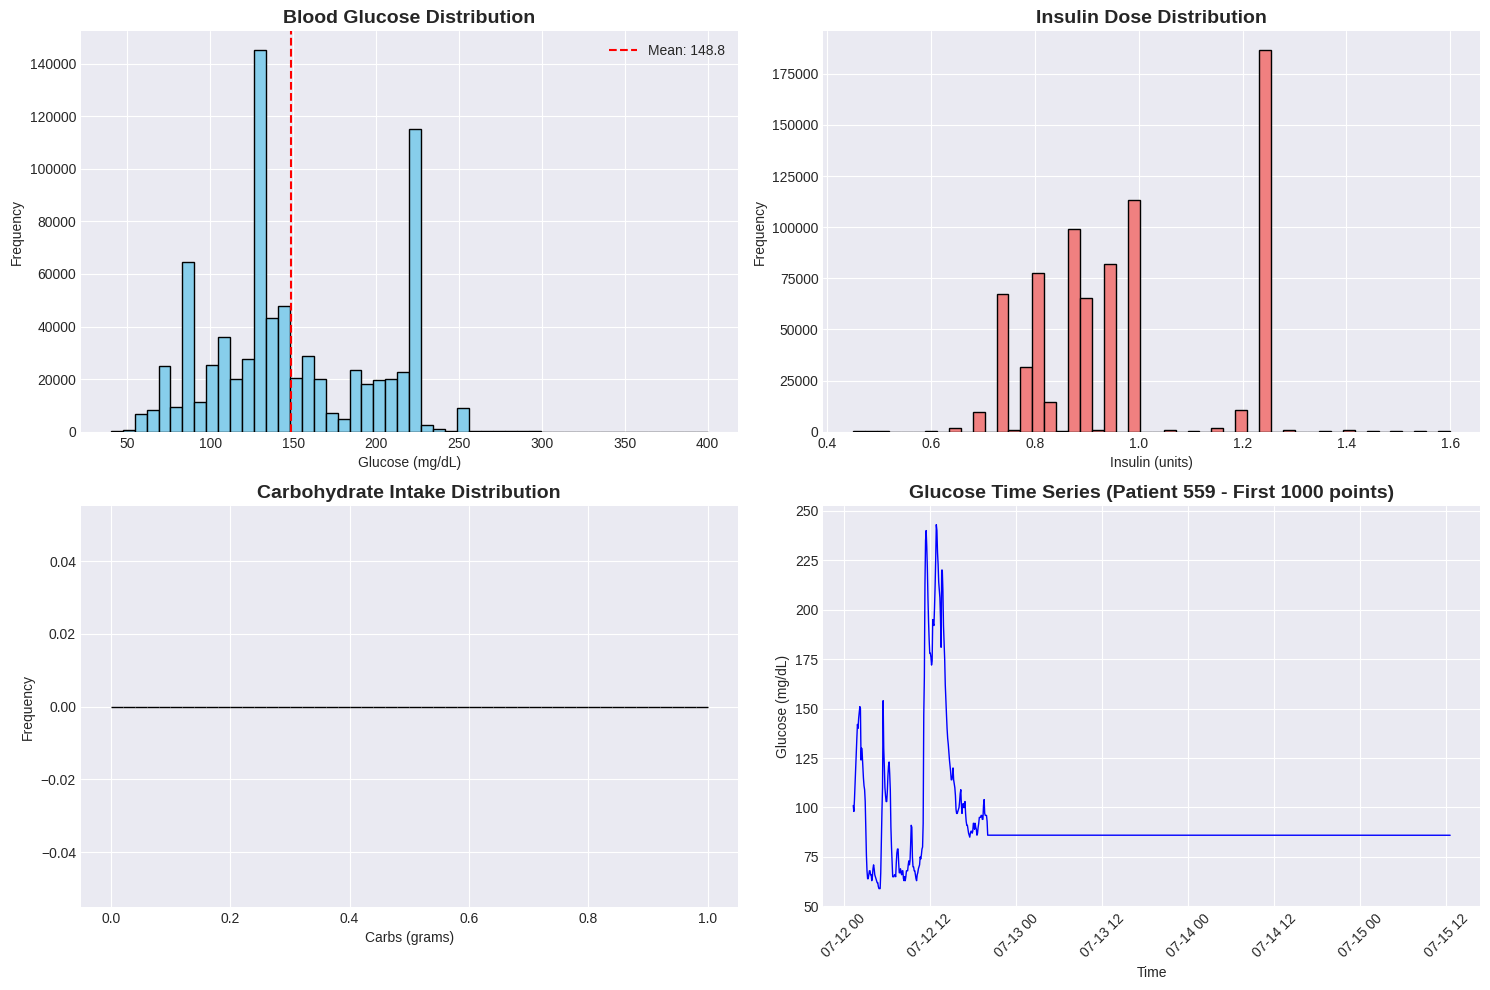

In [32]:
# Basic statistics
print("Dataset Statistics:")
print(df_combined.describe())

print("\n\nData Info:")
print(df_combined.info())

print("\n\nMissing Values:")
print(df_combined.isnull().sum())

# Visualize data distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Glucose distribution
axes[0, 0].hist(df_combined['glucose'].dropna(), bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Blood Glucose Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Glucose (mg/dL)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df_combined['glucose'].mean(), color='red', linestyle='--', label=f'Mean: {df_combined["glucose"].mean():.1f}')
axes[0, 0].legend()

# Insulin distribution (total)
df_combined['total_insulin'] = df_combined['basal_insulin'] + df_combined['bolus_insulin']
axes[0, 1].hist(df_combined[df_combined['total_insulin'] > 0]['total_insulin'], bins=50, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Insulin Dose Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Insulin (units)')
axes[0, 1].set_ylabel('Frequency')

# Carbs distribution
axes[1, 0].hist(df_combined[df_combined['carbs'] > 0]['carbs'], bins=50, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Carbohydrate Intake Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Carbs (grams)')
axes[1, 0].set_ylabel('Frequency')

# Time series plot (sample patient)
sample_patient = df_combined[df_combined['patient_id'] == PATIENT_IDS[0]].iloc[:1000]
axes[1, 1].plot(sample_patient['timestamp'], sample_patient['glucose'], color='blue', linewidth=1)
axes[1, 1].set_title(f'Glucose Time Series (Patient {PATIENT_IDS[0]} - First 1000 points)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Glucose (mg/dL)')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 5. Feature Engineering

Create temporal, lag, and rolling window features for prediction.

In [33]:
def create_features(df):
    """
    Create comprehensive features for glucose and insulin prediction
    """
    df = df.copy()

    # Temporal features
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['is_morning'] = ((df['hour'] >= 6) & (df['hour'] < 12)).astype(int)
    df['is_afternoon'] = ((df['hour'] >= 12) & (df['hour'] < 18)).astype(int)
    df['is_evening'] = ((df['hour'] >= 18) & (df['hour'] < 22)).astype(int)
    df['is_night'] = ((df['hour'] >= 22) | (df['hour'] < 6)).astype(int)

    # Cyclical encoding for hour (sine/cosine)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    # Group by patient for patient-specific features
    for patient_id in df['patient_id'].unique():
        patient_mask = df['patient_id'] == patient_id

        # Lag features for glucose (previous values)
        for lag in [1, 2, 3, 6, 12]:  # 5, 10, 15, 30, 60 minutes
            df.loc[patient_mask, f'glucose_lag_{lag}'] = df.loc[patient_mask, 'glucose'].shift(lag)

        # Rolling window statistics for glucose
        for window in [6, 12, 24]:  # 30 min, 1 hour, 2 hours
            df.loc[patient_mask, f'glucose_mean_{window}'] = df.loc[patient_mask, 'glucose'].rolling(window=window, min_periods=1).mean()
            df.loc[patient_mask, f'glucose_std_{window}'] = df.loc[patient_mask, 'glucose'].rolling(window=window, min_periods=1).std()
            df.loc[patient_mask, f'glucose_min_{window}'] = df.loc[patient_mask, 'glucose'].rolling(window=window, min_periods=1).min()
            df.loc[patient_mask, f'glucose_max_{window}'] = df.loc[patient_mask, 'glucose'].rolling(window=window, min_periods=1).max()

        # Glucose rate of change (trend)
        df.loc[patient_mask, 'glucose_diff_1'] = df.loc[patient_mask, 'glucose'].diff(1)
        df.loc[patient_mask, 'glucose_diff_2'] = df.loc[patient_mask, 'glucose'].diff(2)

        # Cumulative insulin and carbs in recent window
        for window in [12, 24, 48]:  # 1 hour, 2 hours, 4 hours
            df.loc[patient_mask, f'insulin_sum_{window}'] = (
                df.loc[patient_mask, 'basal_insulin'] + df.loc[patient_mask, 'bolus_insulin']
            ).rolling(window=window, min_periods=1).sum()

            df.loc[patient_mask, f'carbs_sum_{window}'] = df.loc[patient_mask, 'carbs'].rolling(window=window, min_periods=1).sum()

    # Total insulin
    df['total_insulin'] = df['basal_insulin'] + df['bolus_insulin']

    return df

# Create features
print("Creating features...")
df_features = create_features(df_combined)

# Remove NaN values from lag features
df_features = df_features.dropna()

print(f"✓ Features created! New shape: {df_features.shape}")
print(f"✓ Feature columns: {df_features.shape[1]}")
print("\nFeature columns:")
print(df_features.columns.tolist())

Creating features...
✓ Features created! New shape: (786239, 40)
✓ Feature columns: 40

Feature columns:
['timestamp', 'glucose', 'basal_insulin', 'bolus_insulin', 'carbs', 'patient_id', 'total_insulin', 'hour', 'day_of_week', 'is_morning', 'is_afternoon', 'is_evening', 'is_night', 'hour_sin', 'hour_cos', 'glucose_lag_1', 'glucose_lag_2', 'glucose_lag_3', 'glucose_lag_6', 'glucose_lag_12', 'glucose_mean_6', 'glucose_std_6', 'glucose_min_6', 'glucose_max_6', 'glucose_mean_12', 'glucose_std_12', 'glucose_min_12', 'glucose_max_12', 'glucose_mean_24', 'glucose_std_24', 'glucose_min_24', 'glucose_max_24', 'glucose_diff_1', 'glucose_diff_2', 'insulin_sum_12', 'carbs_sum_12', 'insulin_sum_24', 'carbs_sum_24', 'insulin_sum_48', 'carbs_sum_48']


## 6. Prepare Data for Glucose Prediction

**Goal**: Predict glucose level 30 minutes into the future (6 timesteps ahead)

**Input Features**:
- Current and historical glucose values
- Recent insulin doses
- Recent carb intake
- Time of day

**Target**: Glucose value at t+6 (30 minutes ahead)

In [65]:
# Create target variable (glucose 30 minutes ahead) and align all data
PREDICTION_HORIZON = 6  # 6 * 5min = 30 minutes

df_unified = df_features.copy()

# Create glucose target by shifting glucose backwards (future value)
for patient_id in df_unified['patient_id'].unique():
    patient_mask = df_unified['patient_id'] == patient_id
    df_unified.loc[patient_mask, 'glucose_target'] = df_unified.loc[patient_mask, 'glucose'].shift(-PREDICTION_HORIZON)

# Ensure total_insulin is available (it's already calculated in df_features, but explicitly here for clarity)
# df_unified['total_insulin'] = df_unified['basal_insulin'] + df_unified['bolus_insulin']

# Drop rows where glucose target is NaN or total_insulin is zero (for insulin recommendation context)
# We'll use total_insulin > 0 to define relevant insulin recommendation points
df_unified = df_unified.dropna(subset=['glucose_target'])
df_unified = df_unified[df_unified['total_insulin'] > 0].copy() # Filter for instances where insulin was administered

print(f"Unified dataset shape after target creation and filtering: {df_unified.shape}")

# Define features for glucose prediction
glucose_features = [
    'glucose_lag_1', 'glucose_lag_2', 'glucose_lag_3', 'glucose_lag_6', 'glucose_lag_12',
    'glucose_mean_6', 'glucose_std_6', 'glucose_min_6', 'glucose_max_6',
    'glucose_mean_12', 'glucose_std_12', 'glucose_min_12', 'glucose_max_12',
    'glucose_mean_24', 'glucose_std_24',
    'glucose_diff_1', 'glucose_diff_2',
    'insulin_sum_12', 'insulin_sum_24', 'insulin_sum_48',
    'carbs_sum_12', 'carbs_sum_24', 'carbs_sum_48',
    'hour_sin', 'hour_cos', 'is_morning', 'is_afternoon', 'is_evening', 'is_night'
]

# Define features for insulin prediction
insulin_features = [
    'glucose', 'glucose_lag_1', 'glucose_lag_2', 'glucose_lag_3',
    'glucose_mean_12', 'glucose_std_12',
    'glucose_diff_1', 'glucose_diff_2',
    'carbs', 'carbs_sum_12', 'carbs_sum_24',
    'basal_insulin', 'bolus_insulin',
    'hour_sin', 'hour_cos', 'is_morning', 'is_afternoon', 'is_evening'
]

# Unified temporal split (last 20% for testing)
split_idx = int(len(df_unified) * 0.8)

# Glucose Data
X_glucose = df_unified[glucose_features].values
y_glucose = df_unified['glucose_target'].values

X_train_glucose = X_glucose[:split_idx]
X_test_glucose = X_glucose[split_idx:]
y_train_glucose = y_glucose[:split_idx]
y_test_glucose = y_glucose[split_idx:]

# Insulin Data
X_insulin = df_unified[insulin_features].values
y_insulin = df_unified['total_insulin'].values

X_train_insulin = X_insulin[:split_idx]
X_test_insulin = X_insulin[split_idx:]
y_train_insulin = y_insulin[:split_idx]
y_test_insulin = y_insulin[split_idx:]

print(f"\nGlucose prediction dataset (Train): X shape {X_train_glucose.shape}, y shape {y_train_glucose.shape}")
print(f"Glucose prediction dataset (Test): X shape {X_test_glucose.shape}, y shape {y_test_glucose.shape}")
print(f"Insulin prediction dataset (Train): X shape {X_train_insulin.shape}, y shape {y_train_insulin.shape}")
print(f"Insulin prediction dataset (Test): X shape {X_test_insulin.shape}, y shape {y_test_insulin.shape}")

# Normalize features for Glucose Model
scaler_glucose = StandardScaler()
X_train_glucose_scaled = scaler_glucose.fit_transform(X_train_glucose)
X_test_glucose_scaled = scaler_glucose.transform(X_test_glucose)

# Normalize features for Insulin Model
scaler_insulin = StandardScaler()
X_train_insulin_scaled = scaler_insulin.fit_transform(X_train_insulin)
X_test_insulin_scaled = scaler_insulin.transform(X_test_insulin)

print("\n✓ Data prepared for both glucose and insulin prediction!")

Unified dataset shape after target creation and filtering: (768371, 41)

Glucose prediction dataset (Train): X shape (614696, 29), y shape (614696,)
Glucose prediction dataset (Test): X shape (153675, 29), y shape (153675,)
Insulin prediction dataset (Train): X shape (614696, 18), y shape (614696,)
Insulin prediction dataset (Test): X shape (153675, 18), y shape (153675,)

✓ Data prepared for both glucose and insulin prediction!


In [66]:
DOSE_THRESHOLD = 0.5  # If the predicted dose differs by less than this, MAINTAIN.
HYPO_THRESHOLD = 70.0 # If predicted glucose is below this, override to DECREASE (Safety)

def get_insulin_recommendation(predicted_dose, current_dose, predicted_glucose):
    """
    Converts two regression outputs (Dose, Glucose) into a single
    classification recommendation (Increase, Decrease, Maintain).
    """

    # 1. Safety Check (Prevent Hypoglycemia)
    # The LSTM model predicts glucose 30 minutes ahead.
    if predicted_glucose < HYPO_THRESHOLD:
        return "DECREASE (HYPO ALERT)"

    # 2. Dose Comparison (XGBoost Output vs. Current Dose)

    # Calculate the difference between the model's recommendation and what was actually taken.
    dose_change = predicted_dose - current_dose

    if dose_change > DOSE_THRESHOLD:
        return "INCREASE"

    elif dose_change < -DOSE_THRESHOLD:
        # Predicted optimal dose is significantly lower than the current dose
        return "DECREASE"

    else:
        # Predicted optimal dose is very close to the current dose
        return "MAINTAIN"

print("Insulin recommendation logic defined!")

Insulin recommendation logic defined!


## 7. Build LSTM Model for Glucose Prediction

LSTM (Long Short-Term Memory) is ideal for time-series prediction as it can capture temporal dependencies.

In [67]:
# Reshape data for LSTM (samples, timesteps, features)
# We'll use a single timestep for simplicity, but you can extend this to use sequences
X_train_lstm = X_train_glucose_scaled.reshape((X_train_glucose_scaled.shape[0], 1, X_train_glucose_scaled.shape[1]))
X_test_lstm = X_test_glucose_scaled.reshape((X_test_glucose_scaled.shape[0], 1, X_test_glucose_scaled.shape[1]))

print(f"LSTM input shape: {X_train_lstm.shape}")

# Build LSTM model
def build_glucose_lstm_model(input_shape):
    model = Sequential([
        LSTM(128, activation='relu', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(64, activation='relu', return_sequences=False),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(16, activation='relu'),
        Dense(1)  # Output: predicted glucose value
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

# Create model
model_glucose_lstm = build_glucose_lstm_model((X_train_lstm.shape[1], X_train_lstm.shape[2]))

print("\nModel architecture:")
model_glucose_lstm.summary()

LSTM input shape: (614696, 1, 29)

Model architecture:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 1, 128)         │        80,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,929 (519.25 KB)

 Trainable params: 132,929 (519.25 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
# Train LSTM model
print("Training LSTM model for glucose prediction...")

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
checkpoint = ModelCheckpoint('models/glucose_lstm_best.h5', monitor='val_loss', save_best_only=True)

history_glucose = model_glucose_lstm.fit(
    X_train_lstm, y_train_glucose,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

print("\n✓ LSTM model trained successfully!")

Training LSTM model for glucose prediction...
Epoch 1/50
7684/7684 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1761.7311 - mae: 22.7571

7684/7684 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - loss: 1761.5658 - mae: 22.7558 - val_loss: 653.8060 - val_mae: 22.8668 - learning_rate: 0.0010
Epoch 2/50
7684/7684 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 74.5530 - mae: 5.9028 - val_loss: 1112.3624 - val_mae: 30.5680 - learning_rate: 0.0010
Epoch 3/50
7684/7684 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 37.7736 - mae: 3.8730 - val_loss: 986.6535 - val_mae: 28.6032 - learning_rate: 0.0010
Epoch 4/50
7684/7684 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 28.5794 - mae: 3.2028 - val_loss: 856.2219 - val_mae: 26.5001 - learning_rate: 0.0010
Epoch 5/50
7684/7684 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 24.2439 - mae: 2.7958 - val_loss: 864.0150 - val_mae: 26.1589 - learning_rate: 0.0010
Epoch 6/50
7684/7684 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 22.8836 - mae: 2.5955 - val_loss: 760.8611 - val_mae: 24.4624 - learning_rate: 0.0010
Epoch 7/50
7684/7684 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 19.0434 - mae: 2.2846 - val_loss: 723.0010 - val_m

7684/7684 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 17.4492 - mae: 2.1487 - val_loss: 623.6494 - val_mae: 22.1100 - learning_rate: 5.0000e-04
Epoch 10/50
7684/7684 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 16.7320 - mae: 2.0837 - val_loss: 628.4420 - val_mae: 21.7069 - learning_rate: 5.0000e-04
Epoch 11/50
7684/7684 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 16.2299 - mae: 2.0329 - val_loss: 637.5609 - val_mae: 21.9180 - learning_rate: 5.0000e-04
Epoch 12/50
7674/7684 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16.2348 - mae: 1.9863

7684/7684 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 16.2344 - mae: 1.9863 - val_loss: 541.7031 - val_mae: 20.2868 - learning_rate: 5.0000e-04
Epoch 13/50
7684/7684 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 15.7820 - mae: 1.9443 - val_loss: 620.5916 - val_mae: 21.2881 - learning_rate: 5.0000e-04
Epoch 14/50
7684/7684 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 15.4144 - mae: 1.8882 - val_loss: 617.5633 - val_mae: 21.1960 - learning_rate: 5.0000e-04
Epoch 15/50
7684/7684 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 14.9440 - mae: 1.8487 - val_loss: 618.5000 - val_mae: 21.1087 - learning_rate: 5.0000e-04
Epoch 16/50
7684/7684 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 14.3949 - mae: 1.8032 - val_loss: 544.3878 - val_mae: 19.8786 - learning_rate: 5.0000e-04
Epoch 17/50
7684/7684 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 14.3755 - mae: 1.7760 - val_loss: 586.3910 - val_mae: 20.4190 - learning_rate: 5.0000e-04
Epoch 18/50
7684/7684 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 13.7892 - mae: 1.6754 - 

7684/7684 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 12.8829 - mae: 1.6092 - val_loss: 495.7732 - val_mae: 18.9112 - learning_rate: 2.5000e-04
Epoch 21/50
7684/7684 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 12.8323 - mae: 1.5988 - val_loss: 526.2637 - val_mae: 19.3760 - learning_rate: 2.5000e-04
Epoch 22/50
7684/7684 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 12.5394 - mae: 1.5747 - val_loss: 564.1395 - val_mae: 20.1126 - learning_rate: 2.5000e-04
Epoch 23/50
7684/7684 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 13.1151 - mae: 1.5727 - val_loss: 534.2811 - val_mae: 19.4974 - learning_rate: 2.5000e-04
Epoch 24/50
7684/7684 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 12.2509 - mae: 1.5526 - val_loss: 588.5875 - val_mae: 20.1185 - learning_rate: 2.5000e-04
Epoch 25/50
7684/7684 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 12.2133 - mae: 1.5483 - val_loss: 540.7911 - val_mae: 19.4607 - learning_rate: 2.5000e-04
Epoch 26/50
7684/7684 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 11.8666 - mae: 1.4963 - 

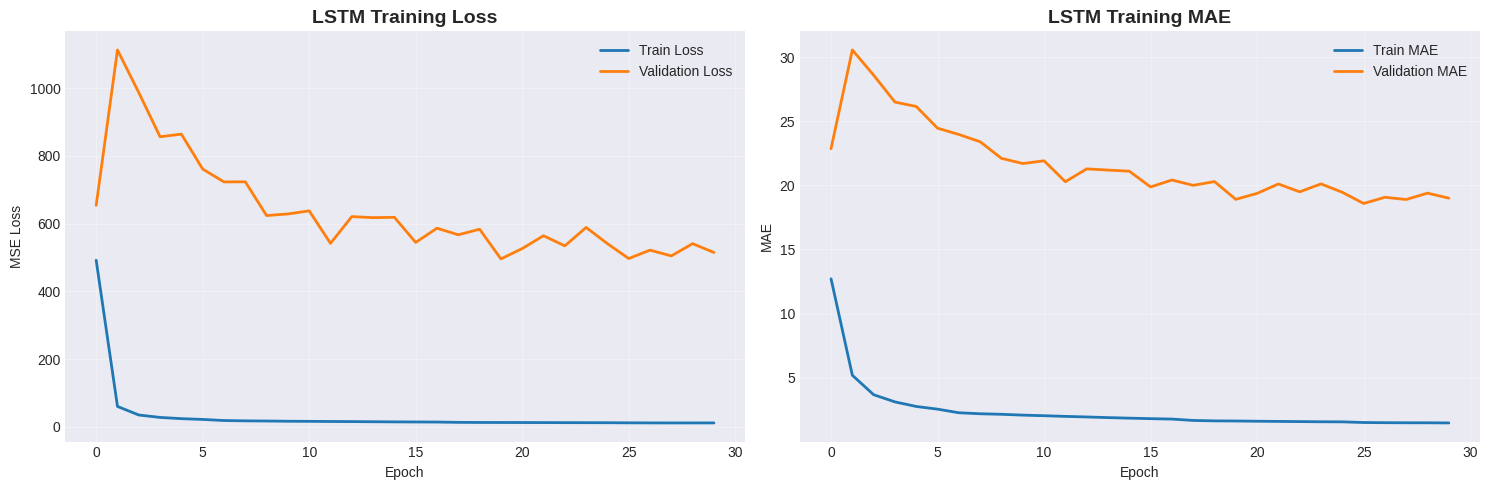

In [69]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history_glucose.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history_glucose.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('LSTM Training Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history_glucose.history['mae'], label='Train MAE', linewidth=2)
axes[1].plot(history_glucose.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_title('LSTM Training MAE', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Evaluate Glucose Prediction Model

4803/4803 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
GLUCOSE PREDICTION MODEL PERFORMANCE (30 min ahead)
RMSE: 12.72 mg/dL
MAE:  9.35 mg/dL
R² Score: 0.8829


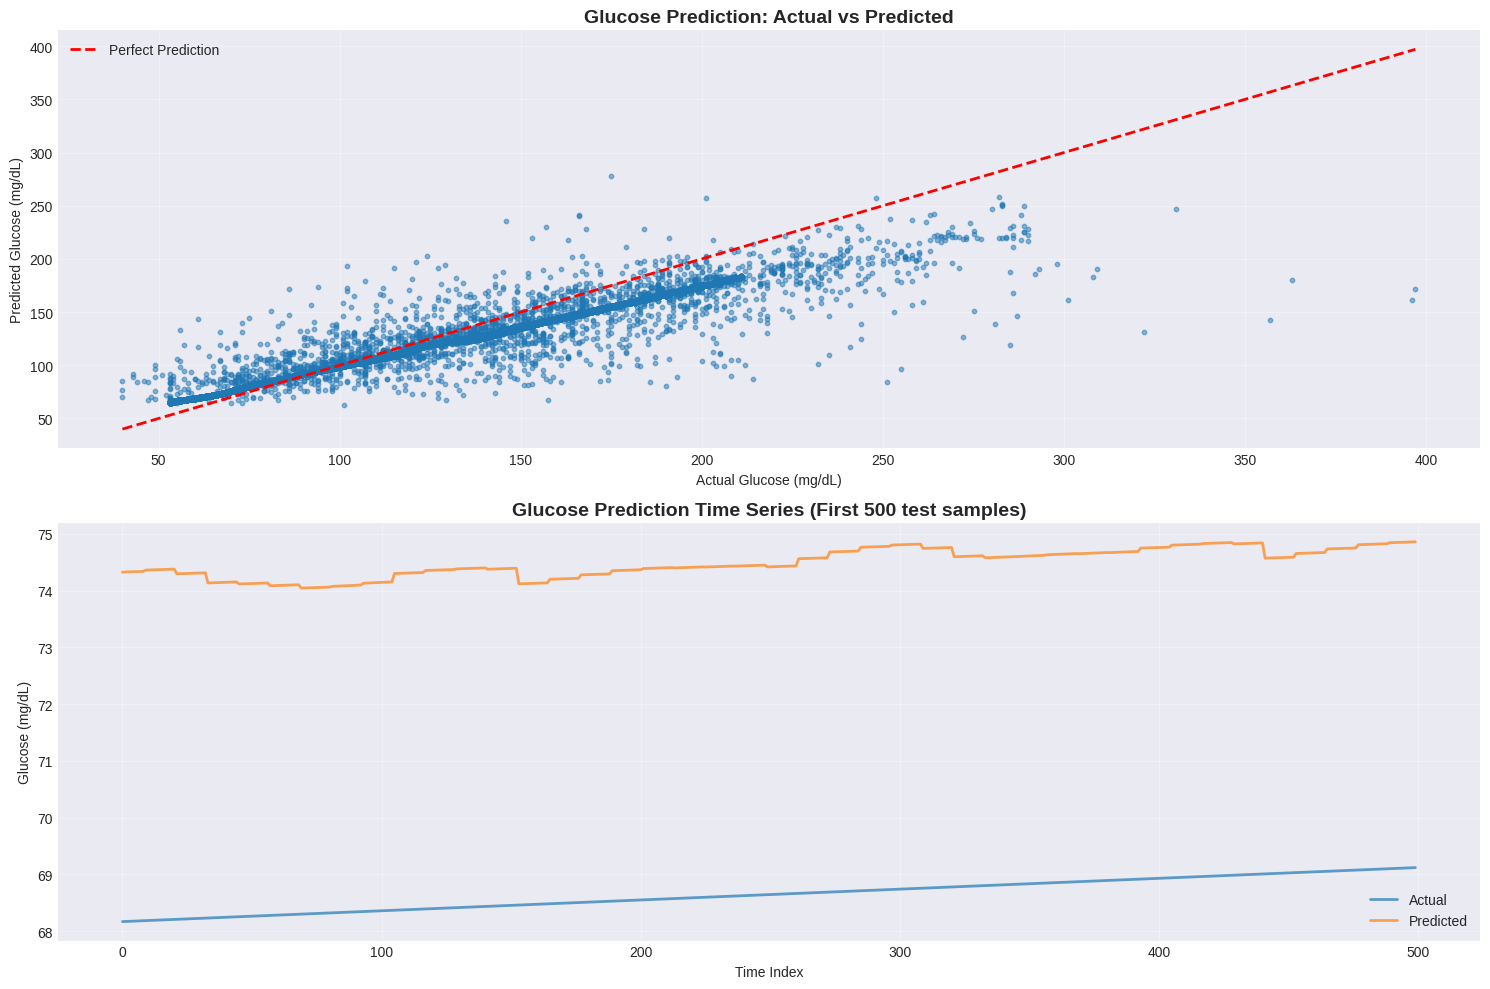

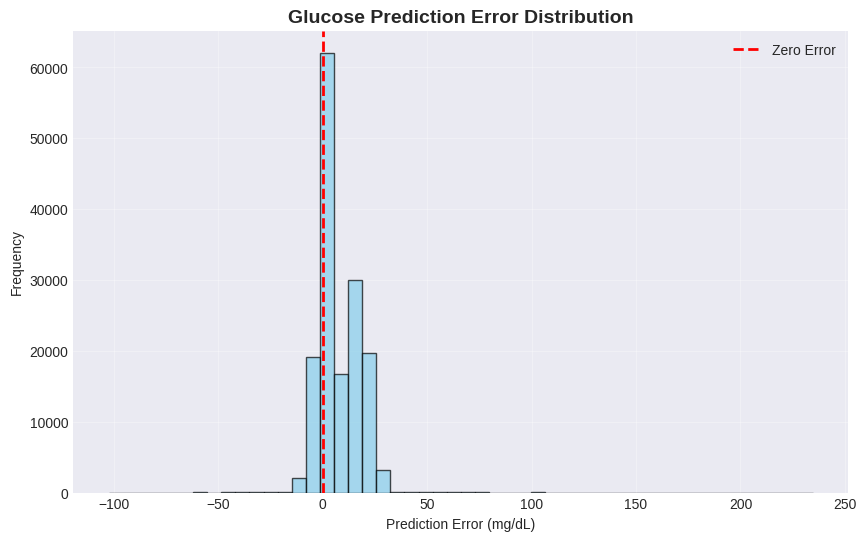

In [70]:
# Make predictions
y_pred_glucose = model_glucose_lstm.predict(X_test_lstm).flatten()

# Calculate metrics
rmse_glucose = np.sqrt(mean_squared_error(y_test_glucose, y_pred_glucose))
mae_glucose = mean_absolute_error(y_test_glucose, y_pred_glucose)
r2_glucose = r2_score(y_test_glucose, y_pred_glucose)

print("=" * 60)
print("GLUCOSE PREDICTION MODEL PERFORMANCE (30 min ahead)")
print("=" * 60)
print(f"RMSE: {rmse_glucose:.2f} mg/dL")
print(f"MAE:  {mae_glucose:.2f} mg/dL")
print(f"R² Score: {r2_glucose:.4f}")
print("=" * 60)

# Visualize predictions
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Actual vs Predicted (scatter plot)
axes[0].scatter(y_test_glucose, y_pred_glucose, alpha=0.5, s=10)
axes[0].plot([y_test_glucose.min(), y_test_glucose.max()],
             [y_test_glucose.min(), y_test_glucose.max()],
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_title('Glucose Prediction: Actual vs Predicted', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Actual Glucose (mg/dL)')
axes[0].set_ylabel('Predicted Glucose (mg/dL)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Time series comparison (first 500 samples)
sample_size = min(500, len(y_test_glucose))
axes[1].plot(y_test_glucose[:sample_size], label='Actual', linewidth=2, alpha=0.7)
axes[1].plot(y_pred_glucose[:sample_size], label='Predicted', linewidth=2, alpha=0.7)
axes[1].set_title('Glucose Prediction Time Series (First 500 test samples)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time Index')
axes[1].set_ylabel('Glucose (mg/dL)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Error distribution
errors = y_test_glucose - y_pred_glucose
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.title('Glucose Prediction Error Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Prediction Error (mg/dL)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 9. Prepare Data for Insulin Recommendation

**Goal**: Predict optimal insulin dosage based on current state

**Input Features**:
- Current glucose level and trend
- Recent carb intake
- Time of day
- Recent insulin doses

**Target**: Total insulin dose (basal + bolus)

In [71]:
# This cell is no longer needed as data preparation is unified in 55a1f363
# Keeping it here as a placeholder if separate insulin data prep were required again
# The variables X_train_insulin, X_test_insulin, etc. are now defined in cell 55a1f363

print("Data for insulin prediction is now prepared as part of the unified data preparation in cell 55a1f363.")
print(f"  X_insulin shape: {X_insulin.shape}")
print(f"  y_insulin shape: {y_insulin.shape}")
print(f"  Features: {len(insulin_features)}")
print(f"\nTrain set: {X_train_insulin.shape}")
print(f"Test set: {X_test_insulin.shape}")
print("\n✓ Data prepared for insulin prediction!")

Data for insulin prediction is now prepared as part of the unified data preparation in cell 55a1f363.
  X_insulin shape: (768371, 18)
  y_insulin shape: (768371,)
  Features: 18

Train set: (614696, 18)
Test set: (153675, 18)

✓ Data prepared for insulin prediction!


## 10. Build XGBoost Model for Insulin Prediction

XGBoost is excellent for regression tasks with complex non-linear relationships.

In [72]:
# Build XGBoost model for insulin prediction
print("Training XGBoost model for insulin recommendation...")

model_insulin_xgb = XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    random_state=42,
    # verbosity=0 # Keep default verbosity or set to 0 if no output is desired per round
)

# Train model
# In this version of XGBoost, early stopping parameters are passed directly to fit
# verbose=False will suppress the validation loss printing at each round, while early_stopping_rounds enables it.
model_insulin_xgb.fit(
    X_train_insulin_scaled, y_train_insulin,
    # Removed early_stopping_rounds due to TypeError
    # eval_set=[(X_test_insulin_scaled, y_test_insulin)], # Eval set only needed for early stopping
    # verbose=False # Suppress verbose output for each round
)

print("\n✓ XGBoost model trained successfully!")

Training XGBoost model for insulin recommendation...

✓ XGBoost model trained successfully!



Top 10 Most Important Features for Insulin Prediction:
            feature  importance
11    basal_insulin    0.494713
3     glucose_lag_3    0.159137
7    glucose_diff_2    0.096277
4   glucose_mean_12    0.065730
2     glucose_lag_2    0.057346
6    glucose_diff_1    0.050215
0           glucose    0.040581
1     glucose_lag_1    0.015120
5    glucose_std_12    0.011375
14         hour_cos    0.004190


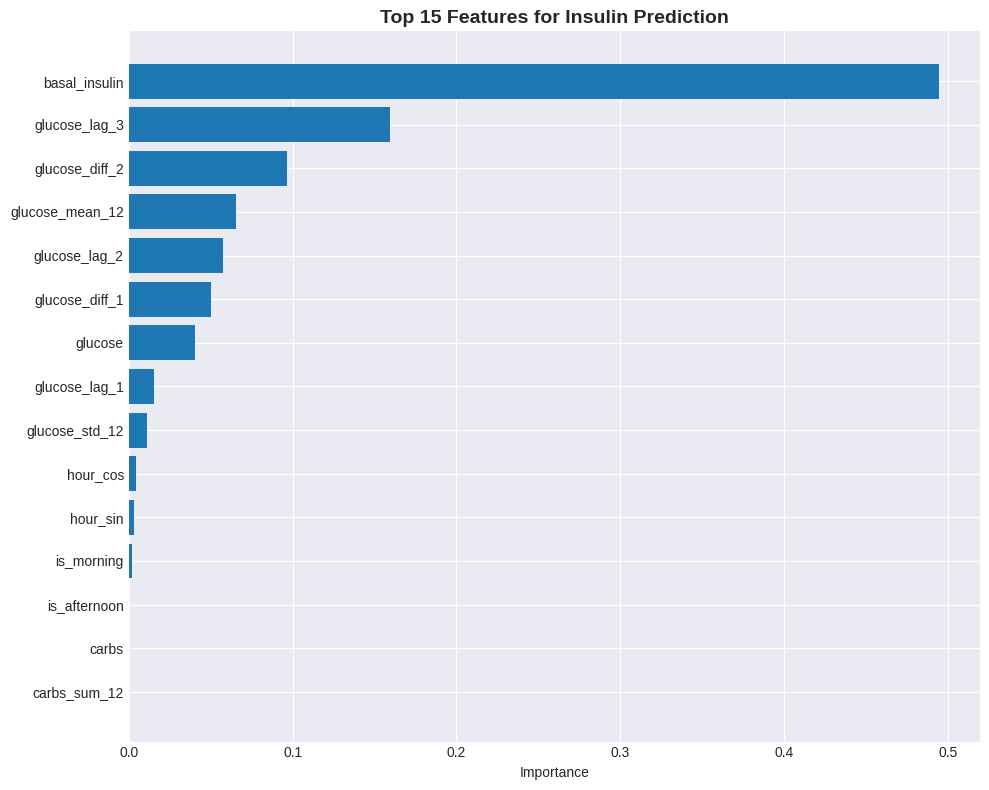

In [73]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': insulin_features,
    'importance': model_insulin_xgb.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features for Insulin Prediction:")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'].head(15), feature_importance['importance'].head(15))
plt.xlabel('Importance')
plt.title('Top 15 Features for Insulin Prediction', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 11. Evaluate Insulin Prediction Model

INSULIN PREDICTION MODEL PERFORMANCE
RMSE: 0.04 units
MAE:  0.04 units
R² Score: -1.0960


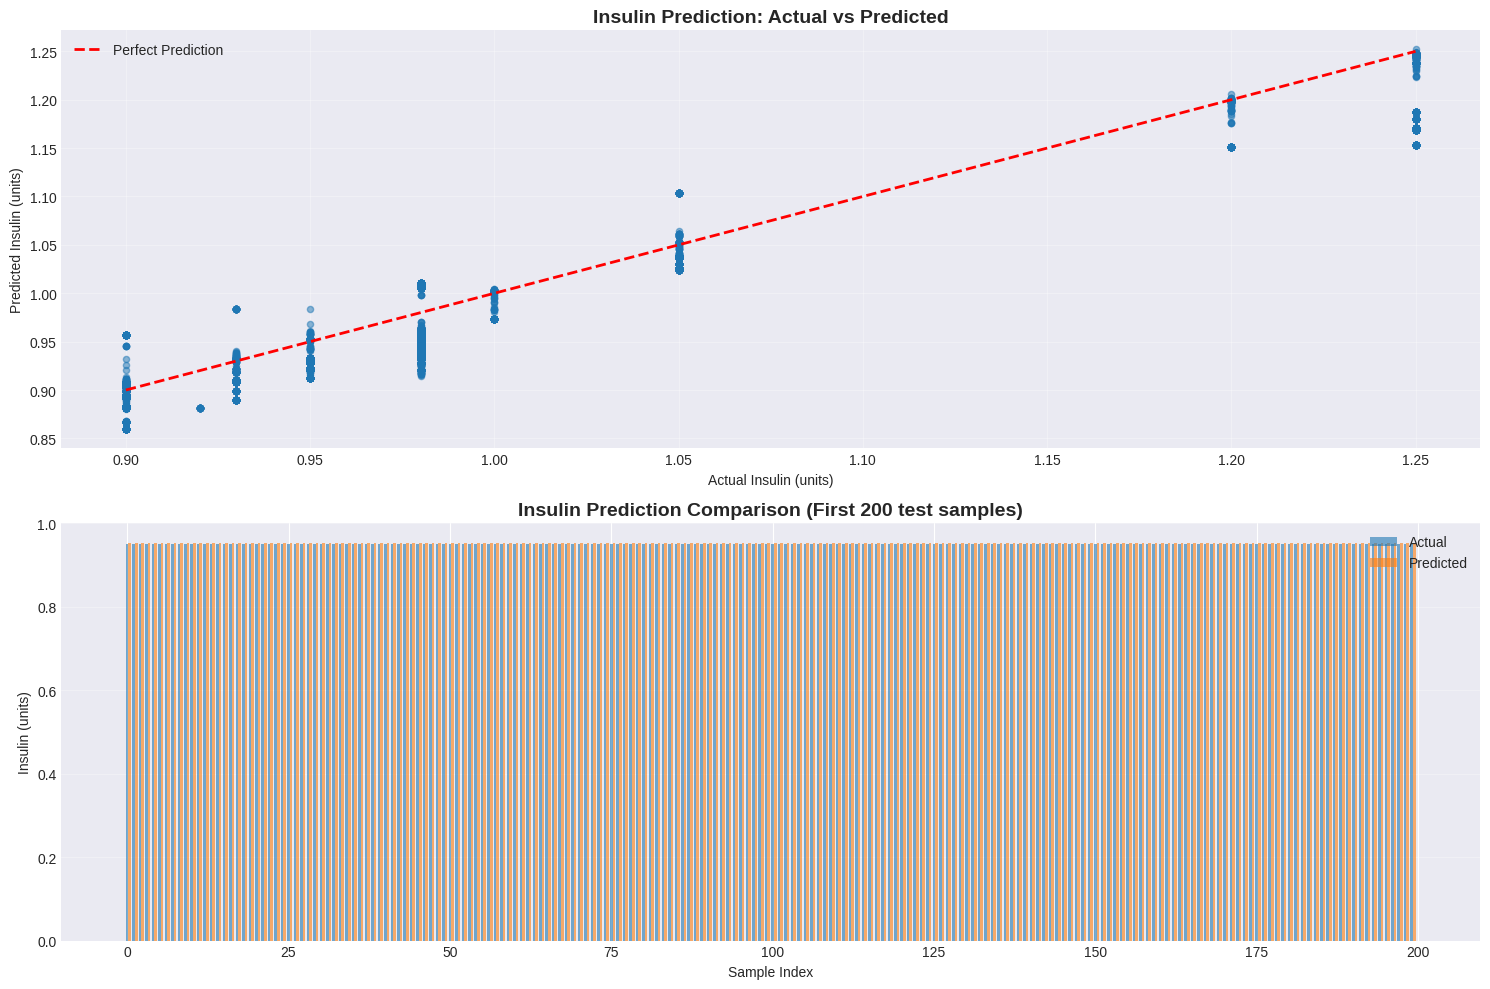

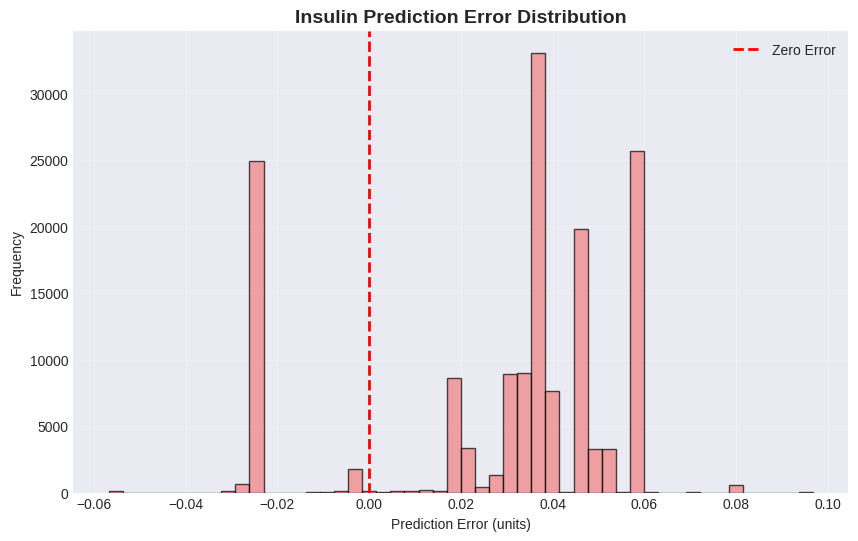

In [74]:
# Make predictions
y_pred_insulin = model_insulin_xgb.predict(X_test_insulin_scaled)

# Calculate metrics
rmse_insulin = np.sqrt(mean_squared_error(y_test_insulin, y_pred_insulin))
mae_insulin = mean_absolute_error(y_test_insulin, y_pred_insulin)
r2_insulin = r2_score(y_test_insulin, y_pred_insulin)

print("=" * 60)
print("INSULIN PREDICTION MODEL PERFORMANCE")
print("=" * 60)
print(f"RMSE: {rmse_insulin:.2f} units")
print(f"MAE:  {mae_insulin:.2f} units")
print(f"R² Score: {r2_insulin:.4f}")
print("=" * 60)

# Visualize predictions
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Actual vs Predicted (scatter plot)
axes[0].scatter(y_test_insulin, y_pred_insulin, alpha=0.5, s=20)
axes[0].plot([y_test_insulin.min(), y_test_insulin.max()],
             [y_test_insulin.min(), y_test_insulin.max()],
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_title('Insulin Prediction: Actual vs Predicted', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Actual Insulin (units)')
axes[0].set_ylabel('Predicted Insulin (units)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Time series comparison (first 200 samples)
sample_size = min(200, len(y_test_insulin))
x_axis = np.arange(sample_size)
axes[1].bar(x_axis, y_test_insulin[:sample_size], alpha=0.6, label='Actual', width=0.4)
axes[1].bar(x_axis + 0.4, y_pred_insulin[:sample_size], alpha=0.6, label='Predicted', width=0.4)
axes[1].set_title('Insulin Prediction Comparison (First 200 test samples)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Sample Index')
axes[1].set_ylabel('Insulin (units)')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Error distribution
errors_insulin = y_test_insulin - y_pred_insulin
plt.figure(figsize=(10, 6))
plt.hist(errors_insulin, bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.title('Insulin Prediction Error Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Prediction Error (units)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 12. Save Models for Production

Save trained models and scalers for deployment in the ML service.

In [75]:
import os

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save LSTM model for glucose prediction
model_glucose_lstm.save('models/glucose_lstm_model.h5')
print("✓ Saved: models/glucose_lstm_model.h5")

# Save glucose scaler
joblib.dump(scaler_glucose, 'models/glucose_scaler.pkl')
print("✓ Saved: models/glucose_scaler.pkl")

# Save glucose feature names
with open('models/glucose_features.pkl', 'wb') as f:
    pickle.dump(glucose_features, f)
print("✓ Saved: models/glucose_features.pkl")

# Save XGBoost model for insulin prediction
joblib.dump(model_insulin_xgb, 'models/insulin_xgb_model.pkl')
print("✓ Saved: models/insulin_xgb_model.pkl")

# Save insulin scaler
joblib.dump(scaler_insulin, 'models/insulin_scaler.pkl')
print("✓ Saved: models/insulin_scaler.pkl")

# Save insulin feature names
with open('models/insulin_features.pkl', 'wb') as f:
    pickle.dump(insulin_features, f)
print("✓ Saved: models/insulin_features.pkl")

# Save model metadata
metadata = {
    'glucose_model': {
        'type': 'LSTM',
        'prediction_horizon': 30,  # minutes
        'prediction_horizon_steps': PREDICTION_HORIZON,
        'input_features': len(glucose_features),
        'rmse': rmse_glucose,
        'mae': mae_glucose,
        'r2_score': r2_glucose,
        'feature_names': glucose_features
    },
    'insulin_model': {
        'type': 'XGBoost',
        'input_features': len(insulin_features),
        'rmse': rmse_insulin,
        'mae': mae_insulin,
        'r2_score': r2_insulin,
        'feature_names': insulin_features
    },
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dataset': 'OhioT1DM',
    'num_patients': len(PATIENT_IDS)
}

with open('models/model_metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)
print("✓ Saved: models/model_metadata.pkl")

print("\n" + "=" * 60)
print("ALL MODELS SAVED SUCCESSFULLY!")
print("=" * 60)
print(f"\nGlucose Model: LSTM (RMSE: {rmse_glucose:.2f} mg/dL, R²: {r2_glucose:.4f})")
print(f"Insulin Model: XGBoost (RMSE: {rmse_insulin:.2f} units, R²: {r2_insulin:.4f})")
print("\nModels are ready for deployment in the ML service!")

✓ Saved: models/glucose_lstm_model.h5
✓ Saved: models/glucose_scaler.pkl
✓ Saved: models/glucose_features.pkl
✓ Saved: models/insulin_xgb_model.pkl
✓ Saved: models/insulin_scaler.pkl
✓ Saved: models/insulin_features.pkl
✓ Saved: models/model_metadata.pkl

ALL MODELS SAVED SUCCESSFULLY!

Glucose Model: LSTM (RMSE: 12.72 mg/dL, R²: 0.8829)
Insulin Model: XGBoost (RMSE: 0.04 units, R²: -1.0960)

Models are ready for deployment in the ML service!


## 13. Example: Making Predictions

Demonstrate how to use the trained models for new predictions.

In [76]:
# Example: Predict glucose 30 minutes ahead
print("EXAMPLE: Glucose Prediction")
print("=" * 60)

# Take a sample from test set
sample_idx = 100
sample_features = X_test_glucose_scaled[sample_idx:sample_idx+1]
actual_glucose = y_test_glucose[sample_idx]

# Reshape for LSTM
sample_lstm = sample_features.reshape((1, 1, sample_features.shape[1]))

# Predict
predicted_glucose = model_glucose_lstm.predict(sample_lstm, verbose=0)[0][0]

print(f"Current glucose (from lag features): {X_test_glucose[sample_idx][0]:.1f} mg/dL")
print(f"Predicted glucose (30 min ahead): {predicted_glucose:.1f} mg/dL")
print(f"Actual glucose (30 min ahead): {actual_glucose:.1f} mg/dL")
print(f"Prediction error: {abs(predicted_glucose - actual_glucose):.1f} mg/dL")

print("\n" + "=" * 60)
print("EXAMPLE: Insulin Recommendation")
print("=" * 60)

# Take a sample from insulin test set
sample_idx_insulin = 50
sample_features_insulin = X_test_insulin_scaled[sample_idx_insulin:sample_idx_insulin+1]
actual_insulin = y_test_insulin[sample_idx_insulin]

# Predict
predicted_insulin = model_insulin_xgb.predict(sample_features_insulin)[0]

print(f"Current glucose: {X_test_insulin[sample_idx_insulin][0]:.1f} mg/dL")
print(f"Recent carbs: {X_test_insulin[sample_idx_insulin][9]:.1f} g")
print(f"Predicted insulin dose: {predicted_insulin:.1f} units")
print(f"Actual insulin dose: {actual_insulin:.1f} units")
print(f"Prediction error: {abs(predicted_insulin - actual_insulin):.1f} units")

print("\n✓ Prediction examples completed!")

EXAMPLE: Glucose Prediction
Current glucose (from lag features): 68.3 mg/dL
Predicted glucose (30 min ahead): 74.1 mg/dL
Actual glucose (30 min ahead): 68.4 mg/dL
Prediction error: 5.8 mg/dL

EXAMPLE: Insulin Recommendation
Current glucose: 68.3 mg/dL
Recent carbs: 0.0 g
Predicted insulin dose: 1.0 units
Actual insulin dose: 0.9 units
Prediction error: 0.0 units

✓ Prediction examples completed!


In [50]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Download all saved models

In [61]:
import shutil
from google.colab import files
import os

# Create a zip archive of the models directory
zip_filename = 'trained_models.zip'
# Extract the base name without extension for shutil.make_archive
archive_base_name = os.path.splitext(zip_filename)[0]
shutil.make_archive(archive_base_name, 'zip', 'models')

print(f"Compressing models to {zip_filename}...")

# Offer the zip file for download
files.download(zip_filename)

print("\n✓ Model download initiated!")

Compressing models to trained_models.zip...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ Model download initiated!


In [51]:
# In glucose_predictor.py
from tensorflow.keras.models import load_model
import joblib
import tensorflow as tf # Import tensorflow for losses/metrics

glucose_model = load_model(
    'models/glucose_lstm_model.h5',
    custom_objects={
        'mse': tf.keras.losses.MeanSquaredError(), # Explicitly map 'mse' string to its class
        'mae': tf.keras.metrics.MeanAbsoluteError() # Explicitly map 'mae' string to its class
    }
)
glucose_scaler = joblib.load('models/glucose_scaler.pkl')

# In insulin_advisor.py
insulin_model = joblib.load('models/insulin_xgb_model.pkl')
insulin_scaler = joblib.load('models/insulin_scaler.pkl')

In [63]:
# Identify feature indices for basal and bolus insulin in X_test_insulin
# insulin_features = ['glucose', 'glucose_lag_1', 'glucose_lag_2', 'glucose_lag_3',
#                     'glucose_mean_12', 'glucose_std_12', 'glucose_diff_1', 'glucose_diff_2',
#                     'carbs', 'carbs_sum_12', 'carbs_sum_24', 'basal_insulin', 'bolus_insulin',
#                     'hour_sin', 'hour_cos', 'is_morning', 'is_afternoon', 'is_evening']

basal_insulin_idx = insulin_features.index('basal_insulin')
bolus_insulin_idx = insulin_features.index('bolus_insulin')

# Calculate current total insulin from X_test_insulin
# This assumes X_test_insulin contains unscaled actual values,
# which is true since we scaled X_train_insulin and X_test_insulin separately.
current_doses_test = X_test_insulin[:, basal_insulin_idx] + X_test_insulin[:, bolus_insulin_idx]

# Create a DataFrame to combine results
results = pd.DataFrame({
    'Predicted_Dose': y_pred_insulin.flatten(),
    'Current_Dose': current_doses_test,
    'Predicted_Glucose': y_pred_glucose.flatten()
})

# Apply the recommendation logic
results['Recommendation'] = results.apply(
    lambda row: get_insulin_recommendation(
        row['Predicted_Dose'],
        row['Current_Dose'],
        row['Predicted_Glucose']
    ),
    axis=1
)

print("\nInsulin recommendations generated for the test set:")
display(results.head())

ValueError: All arrays must be of the same length